In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#### Load the dataset


In [3]:
df = pd.read_csv('data.csv')

In [4]:
null_counts = df.isnull().sum()
print("Null/Empty counts for each column:")
print(null_counts)

Null/Empty counts for each column:
timestamp_call_key                        0
retailer_code                             0
serial                                    0
reason                                    0
mos                                       0
resolved                                  0
no_of_accounts_with_syf_13_march       3400
account_balance_13_march             113782
delinquency_history_13_march              0
account_open_date_13_march                0
account_status_13_march                   0
card_activation_status_13_march           0
eservice_ind_13_march                     0
ebill_enrolled_status_13_march            0
auto_pay_enrolled_status_13_march         0
no_of_accounts_with_syf_18_march       3402
account_balance_18_march             101829
delinquency_history_18_march              0
account_open_date_18_march                0
account_status_18_march                   0
card_activation_status_18_march           0
eservice_ind_18_march                    

#### Analyzing MOS Sequences


We observe the paths which occur most commonly in MOS Sequences.


In [5]:
from collections import Counter

mos_sequences = df['mos'].str.split().apply(tuple)
most_common_paths = Counter(mos_sequences).most_common()

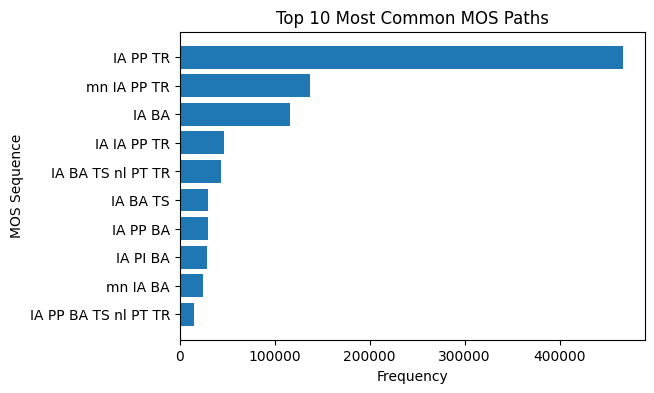

In [8]:
import matplotlib.pyplot as plt

mos_labels = [' '.join(mos) for mos, count in most_common_paths[:10]]
counts = [count for mos, count in most_common_paths[:10]]

plt.figure(figsize=(6, 4))
plt.barh(mos_labels, counts)
plt.xlabel('Frequency')
plt.ylabel('MOS Sequence')
plt.title('Top 10 Most Common MOS Paths')
plt.gca().invert_yaxis()
plt.show()


In [9]:
print(most_common_paths[:10])

[(('IA', 'PP', 'TR'), 466412), (('mn', 'IA', 'PP', 'TR'), 137569), (('IA', 'BA'), 116279), (('IA', 'IA', 'PP', 'TR'), 46700), (('IA', 'BA', 'TS', 'nl', 'PT', 'TR'), 43145), (('IA', 'BA', 'TS'), 30003), (('IA', 'PP', 'BA'), 29874), (('IA', 'PI', 'BA'), 28304), (('mn', 'IA', 'BA'), 24763), (('IA', 'PP', 'BA', 'TS', 'nl', 'PT', 'TR'), 15463)]


As a deep-dive, we group by all unique MOS Sequence combinations. Next, we identify the respective number of times each of them has had a resolution status of "resolved" and "floor", and, accordingly, calculate a Floor Percentage, given by:
(Number of occurrences of Floor for a given MOS Sequence/Total occurrences of the MOS Sequence) \* 100%


In [12]:
mos_sequences_df = df['mos'].str.split().apply(tuple).to_frame(name='mos_sequence_tuple').copy()
mos_sequences_df['resolved_status'] = df['resolved']

grouped_counts = mos_sequences_df.groupby(['mos_sequence_tuple', 'resolved_status']).size().unstack(fill_value=0)

grouped_counts['total_occurrences'] = grouped_counts['resolved'] + grouped_counts['floor']

grouped_counts['floor_percentage'] = (grouped_counts['floor'] / grouped_counts['total_occurrences']) * 100

sorted_grouped_counts = grouped_counts.sort_values(by='floor_percentage', ascending=False)

sorted_grouped_counts.reset_index(inplace=True)

sorted_grouped_counts['mos_sequence'] = sorted_grouped_counts['mos_sequence_tuple'].apply(lambda x: ' '.join(x))

mos_df = sorted_grouped_counts[['mos_sequence', 'floor_percentage', 'total_occurrences', 'resolved', 'floor']].copy()

mos_df.rename(columns={
    'mos_sequence': 'MOS Sequence',
    'floor_percentage': 'Floor Call Percentage',
    'total_occurrences': 'Total Occurrences',
    'resolved': 'Number of Resolved Calls',
    'floor': 'Number of Floor Calls'
}, inplace=True)


We calculate a weighted score for each of the previously obtained unique MOS Sequence.
The score is calculated as a Weighted Harmonic Mean, given by:

Weighted Score = w_fp + w_to / ((w_fp/fp +1) + (w_to/to+1))

Where, w_fp = 0.6, w_to = 0.4

fp denotes "Floor Percentage"
to denotes "Total Occurrences"


In [13]:
w_fp = 0.6 
w_to = 0.4

mos_df['weighted_score'] = (w_fp + w_to) / ((w_fp / (mos_df['Floor Call Percentage'] + 1)) + (w_to / (mos_df['Total Occurrences'] + 1)))

mos_df_sorted = mos_df.sort_values(by='weighted_score', ascending=False)

print(mos_df_sorted[['MOS Sequence', 'Floor Call Percentage', 'Total Occurrences', 'weighted_score']].head(10))


resolved_status             MOS Sequence  Floor Call Percentage  \
22516               IA BA TS nl mt RS TR              99.669754   
22497                  IA BA nl mt RS TR              99.768188   
22492               IA PP BA nl mt RS TR              99.798894   
22598                        IA BA nl TR              99.088624   
22512            IA PP BA TS nl mt RS TR              99.698417   
22513            IA PI BA TS nl mt RS TR              99.690482   
22676                     IA BA TS nl TR              98.465335   
22504            mn IA BA TS nl mt RS TR              99.727438   
22559            IA BA TS nl nl mt RS TR              99.375170   
22611                     mn IA BA nl TR              98.999090   

resolved_status  Total Occurrences  weighted_score  
22516                        12415      166.880870  
22497                         5608      165.959292  
22492                         3978      165.208044  
22598                         6364      165.083762

Ensuring the counts obtained above are accurate, by comparing manually against the Excel.


In [15]:
specific_mos_df = df[df['mos'] == 'IA BA TS nl CT mt RS TR']

resolved_counts = specific_mos_df['resolved'].value_counts()

print(f"Counts for MOS sequence 'IA BA TS nl CT mt RS TR':\n{resolved_counts}")


Counts for MOS sequence 'IA BA TS nl CT mt RS TR':
resolved
floor       1455
resolved       5
Name: count, dtype: int64


Saving the unique MOS sequences along with their weighted scores.


In [9]:
mos_df_sorted.to_csv('mos_analysis.csv', index=False)

### Using Deep Learning


##### Model Training and Testing


Using a Long short-term memory (LSTM) recurrent neural network.

We tokenize all the MOS sequences, as our aim is to capture not just the significance of a sequence, but also the signifiance of the codes which make up a sequence.


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

sequences = mos_df_sorted['MOS Sequence']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
seqs = tokenizer.texts_to_sequences(sequences)
seqs_padded = pad_sequences(seqs, padding='post')

# Prepare labels (1 for floor, 0 for resolved)
labels = np.where(mos_df_sorted['Floor Call Percentage'] > 50, 1, 0)

# Splitting the data 80:20
X_train, X_test, y_train, y_test = train_test_split(seqs_padded, labels, test_size=0.2, random_state=42)

Next, we build the model and set it to training.


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Due to resource constraints, we settled at 5 Epochs of training, but we realize it doesn't take the model long to reach a high level of accuracy.
But there's obviously room for improvement, especially with the loss.


Having obtained our model, we test prediction manually by providing an input MOS sequence string.


In [19]:
def predict_mos_sequence(sequence, model, tokenizer):
    tokenized_seq = tokenizer.texts_to_sequences([sequence])
    padded_seq = pad_sequences(tokenized_seq, maxlen=seqs_padded.shape[1], padding='post')
    
    prediction = model.predict(padded_seq)
    return "Floor" if prediction[0][0] >= 0.5 else "Resolved"

# Testing prediction manually with an input
new_mos = "mn IA PI BA MR"
print(predict_mos_sequence(new_mos, model, tokenizer))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Resolved


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on test data
predictions = model.predict(X_test)
# Convert predictions to binary values (0 or 1)
predictions = (predictions > 0.5).astype(int)

# Assuming y_test and predictions are available
print(classification_report(y_test, predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Using Transformers.

They can capture long-range dependencies more effectively than LSTMs, ideally leading to better performance in understanding context of mos sequences.

We note that the self-attention mechanism present in a Transformer will aid us in weighing the importance of an individual code in a given sequence.


Again, we tokenize all the MOS sequences, and prepare labels.


In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['mos'])
sequences = tokenizer.texts_to_sequences(df['mos'])
max_seq_length = max([len(seq) for seq in sequences])  # Or choose a fixed length
seqs_padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

labels = df['resolved'].apply(lambda x: 1 if x == 'floor' else 0)

X_train, X_test, y_train, y_test = train_test_split(seqs_padded, labels, test_size=0.2, random_state=42)


Building the Transformer


In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization

def transformer_encoder(inputs):
    attention_output = MultiHeadAttention(num_heads=2, key_dim=64)(inputs, inputs)
    attention_output = Dropout(0.1)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    ffn_output = Dense(64, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

inputs = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64)(inputs)
transformer_block = transformer_encoder(embedding_layer)
x = GlobalAveragePooling1D()(transformer_block)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Now, we train the model


In [26]:
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3


44970/44970 ━━━━━━━━━━━━━━━━━━━━ 348s 8ms/step - accuracy: 0.9600 - loss: 0.1439 - val_accuracy: 0.9638 - val_loss: 0.1333
Epoch 2/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 371s 8ms/step - accuracy: 0.9632 - loss: 0.1334 - val_accuracy: 0.9637 - val_loss: 0.1334
Epoch 3/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 388s 9ms/step - accuracy: 0.9636 - loss: 0.1323 - val_accuracy: 0.9634 - val_loss: 0.1335


We notice, our model immediately shows a marked improvement over the results obtained by the LSTM


Again, we run predictions with the model on a sample MOS sequence


In [17]:
def predict_mos_transformer(sequence, model, tokenizer, max_seq_length):
    tokenized_seq = tokenizer.texts_to_sequences([sequence])
    padded_seq = pad_sequences(tokenized_seq, maxlen=max_seq_length, padding='post')
    prediction = model.predict(padded_seq)
    return "Floor" if prediction[0][0] >= 0.5 else "Resolved"

# Example usage
print(predict_mos_transformer("IA AA Ta BA BA BA nl nl", model, tokenizer, max_seq_length))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Resolved


Next, we leverage some metrics, in F-1, AUC, precision, and recall to analyze our model. As we're dealing with binary classification (floor vs resolved), these metrics can provide good insights about the performance of the model.


11243/11243 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step
F1 Score: 0.9057281199264764
AUC Score: 0.9622250819456424
Precision: 0.9516645374614864
Recall: 0.8640221603624256


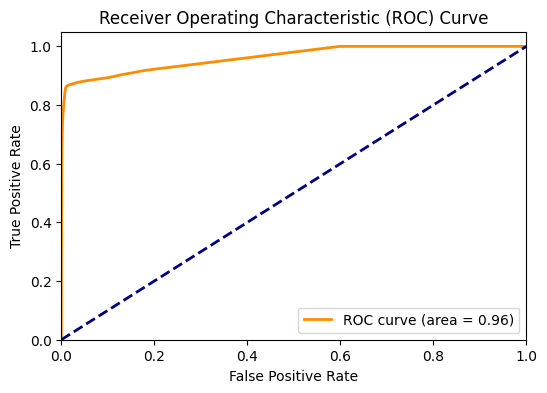

C:\Users\tansw\AppData\Local\Temp\ipykernel_12648\4071259958.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='muted')


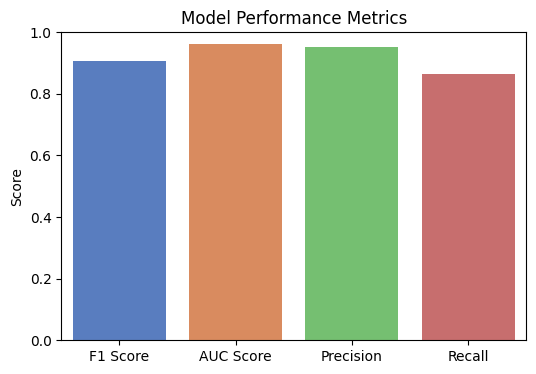

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc

predictions_prob = model.predict(X_test)
predictions = (predictions_prob > 0.5).astype("int32")

f1 = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test, predictions_prob)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"F1 Score: {f1}")
print(f"AUC Score: {auc_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

metrics = ['F1 Score', 'AUC Score', 'Precision', 'Recall']
values = [f1, auc_score, precision, recall]

plt.figure(figsize=(6, 4))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

We observe great F-1 and AUC Scores, even highlighting good precision and recall.


Finally, we save our model


In [30]:
model.save('model.keras')  # Saves the model to a single HDF5 file

Lest we need to load our model for future reference.


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.keras')

Enriching our model

Having trained our Transformer, we look into adding additional features: specifically, highlighting the significance of MOS sequences which contribute to calls that go to the floor. We reiterate, our aim is to minimize the number of floor calls, and for this purpose, it's essential to put an emphasis on what makes calls go to the floor.

Thus, we leverage the weighted scores we'd calculated previously for unique MOS sequences, and we add those scores to our existing dataset.


In [31]:
mos_weighted_df = pd.read_csv('mos_weighted.csv')

df_enriched = pd.merge(df, mos_weighted_df[['MOS Sequence', 'weighted_score']], left_on='mos', right_on='MOS Sequence', how='left')

df_enriched.drop('MOS Sequence', axis=1, inplace=True)

,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,account_balance_13_march,delinquency_history_13_march,account_open_date_13_march,...,delinquency_history_18_march,account_open_date_18_march,account_status_18_march,card_activation_status_18_march,eservice_ind_18_march,ebill_enrolled_status_18_march,auto_pay_enrolled_status_18_march,date_of_call,time_of_call,weighted_score
0,240315173250 DAL1OA3M,D,10010009499,PP,IA PP TR,resolved,1.0,NaN,[00],5/19/2013,...,[00],5/19/2013,N,0,1,E,0,03/15/2024,17:32:50,9.519088
1,240315124742 DAL15XHK,E,10006021998,BA,IA BA TS nl TR,floor,2.0,143.28,[00],9/22/2003,...,[00],9/22/2003,N,0,1,E,0,03/15/2024,12:47:42,164.932199


Next, we normalize the weighted scores and split the dataset for our model.


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
weighted_scores_norm = scaler.fit_transform(df_enriched[['weighted_score']].fillna(0))

labels_enriched = df_enriched['resolved'].apply(lambda x: 1 if x == 'floor' else 0).values

X_train_seqs, X_test_seqs, X_train_scores, X_test_scores, y_train, y_test = train_test_split(seqs_padded, weighted_scores_norm, labels_enriched, test_size=0.2, random_state=42)


Modifying our model to accept an additional input in terms of normalized weighted score.


In [30]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dropout, LayerNormalization, Dense, GlobalAveragePooling1D, concatenate
from tensorflow.keras.models import Model

seq_input = Input(shape=(max_seq_length,), dtype='int32', name='seq_input')
score_input = Input(shape=(1,), name='score_input')

embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64)(seq_input)
transformer_block = transformer_encoder(embedding_layer)
seq_model_output = GlobalAveragePooling1D()(transformer_block)

combined_features = concatenate([seq_model_output, score_input], axis=1)

x = Dense(64, activation='relu')(combined_features)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_enriched = Model(inputs=[seq_input, score_input], outputs=outputs)
model_enriched.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_enriched.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 64)    │      4,928 │ seq_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     33,216 │ embedding_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 12, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 12, 64)    │          0 │ embedding_1[0][0… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 12, 64)    │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 12, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 12, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ score_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

Training our new enriched model


In [31]:
model_enriched.fit([X_train_seqs, X_train_scores], y_train, batch_size=32, epochs=3, validation_data=([X_test_seqs, X_test_scores], y_test))

Epoch 1/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 377s 8ms/step - accuracy: 0.9609 - loss: 0.1405 - val_accuracy: 0.9635 - val_loss: 0.1331
Epoch 2/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 386s 9ms/step - accuracy: 0.9635 - loss: 0.1328 - val_accuracy: 0.9638 - val_loss: 0.1310
Epoch 3/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 395s 9ms/step - accuracy: 0.9638 - loss: 0.1315 - val_accuracy: 0.9636 - val_loss: 0.1306


Albeit very, very marginal, we observe improvements in the model on addition of the new feature in weighted scores of MOS sequences


Saving our enriched model


In [32]:
model_enriched.save('enriched_model.keras')

11243/11243 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step
F1 Score: 0.9058804913835266
AUC Score: 0.9626290424677868
Precision: 0.9577655432534372
Recall: 0.859328093444681


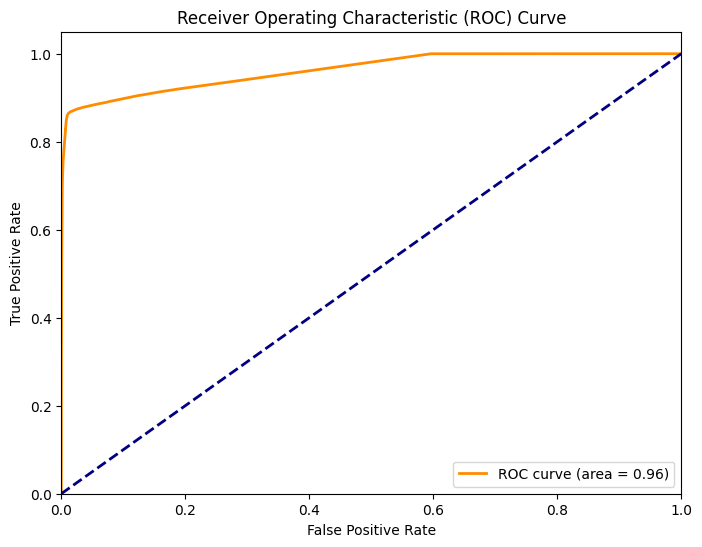

C:\Users\tansw\AppData\Local\Temp\ipykernel_14852\3906178938.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='muted')


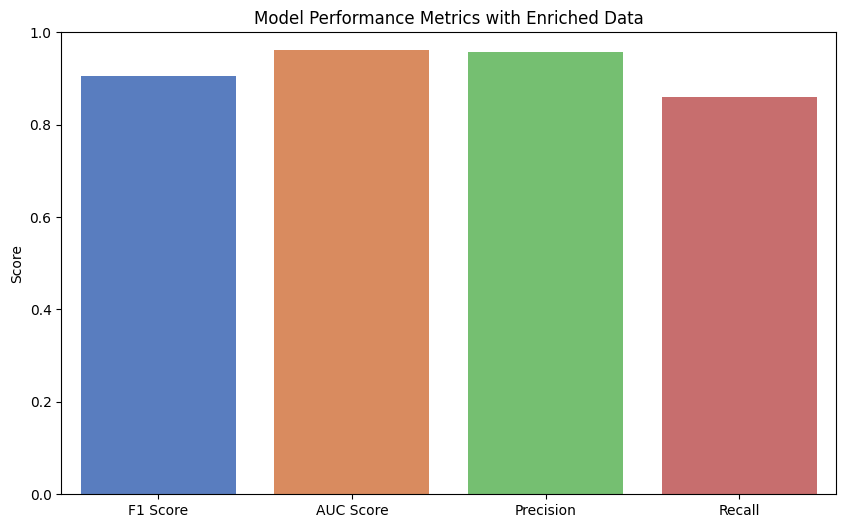

In [33]:
predictions_prob = model_enriched.predict([X_test_seqs, X_test_scores])
predictions = (predictions_prob > 0.5).astype("int32")

f1 = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test, predictions_prob)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"F1 Score: {f1}")
print(f"AUC Score: {auc_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

metrics = ['F1 Score', 'AUC Score', 'Precision', 'Recall']
values = [f1, auc_score, precision, recall]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Model Performance Metrics with Enriched Data')
plt.ylabel('Score')
plt.ylim(0, 1) 
plt.show()

Again, we observe good performances on all metrics


### LLM Incorporation


Having obtained a newly enriched model, one that knows the significance of MOS sequences which lead to calls that go to the floor, we decided to take things up - several - notches.

We were provided a dictionary file, consisting of definitions of MOS codes. 

Examples: AA - Activation, AG - Transferred from agent, AL - Account lookup

Thus, we decided to leverage these definitions. Since they don't provide any inherent metrics, we decided to calculate our own - analyzing the "seriousness" of each definition.


Reading in the MOS definitions dictinary file.

In [36]:
mos_definitions_df = pd.read_csv('./dictionary_files/mos.csv')

print(mos_definitions_df.head())

  code                  status
0   AA              Activation
1   AG  Transferred from agent
2   AL          Account lookup
3   AP    Address phone change
4   AR         APR Information


First, we decide to use Google's BERT (from Hugging Face Transformers library).

In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = TFBertModel.from_pretrained('bert-base-uncased')

def get_code_embedding(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = model_bert(inputs)
    return outputs.pooler_output

We obtain "embeddings" for the MOS sequence.

In [ ]:
mos_definitions_df['embedding'] = mos_definitions_df['Definition'].apply(get_code_embedding)

code_to_embedding = {row['Code']: row['embedding'].numpy()[0] for index, row in mos_definitions_df.iterrows()}

def mos_to_avg_embedding(mos, code_to_embedding):
    codes = mos.split() 
    embeddings = [code_to_embedding[code] for code in codes if code in code_to_embedding]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros((768,)) 

df['mos_embedding'] = df['mos'].apply(lambda x: mos_to_avg_embedding(x, code_to_embedding))


But we realize, a transformer like BERT can't understand "seriousness" - not in the way we want it to.

Thus, we decide to use OpenAI's GPT-3.5 Turbo API.

### Using OpenAI's GPT-3.5 Turbo API

We leverage OpenAI's library, using our API keys [redacted], and provide an extensive prompt explaining our intentions

In [ ]:
import openai

mos_df = pd.read_csv('./dictionary_files/mos.csv') 

openai.api_key = ''

def get_seriousness_score(status):
    response = openai.Completion.create(
      model="text-davinci-003",
      prompt=f"In the context of an IVR system, rate the seriousness of the following description on a scale of 1 to 10: {status}. We call it serious when the description has keywords which indicate that the call should be relayed to a human, as opposed to being handled by an automated system.",
      temperature=0,
      max_tokens=60,
      top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=0.0,
      stop=["\n"]
    )
    try:
        score = [int(s) for s in response.choices[0].text.split() if s.isdigit()][0]
        return score
    except IndexError:
        return None 

mos_df['seriousness_score'] = mos_df['status'].apply(get_seriousness_score)


We obtain seriousness scores for all definitions, and subsequently, normalize them

In [12]:
mos_with_scores_df = pd.read_csv('./dictionary_files/mos_with_score.csv')
mos_with_scores_df['seriousness_score_norm'] = (mos_with_scores_df['seriousness_score'] - 1) / (10 - 1)

Having obtained scores for all codes, we look at all the MOS sequences present in our dataset and calculate average seriousness for a given MOS sequence for all rows

In [13]:
def get_avg_seriousness_for_mos(mos_sequence, code_to_seriousness):
    codes = mos_sequence.split()
    seriousness_scores = [code_to_seriousness.get(code, 0) for code in codes]
    avg_seriousness = np.mean(seriousness_scores) if seriousness_scores else 0
    return avg_seriousness

code_to_seriousness = pd.Series(mos_with_scores_df['seriousness_score_norm'].values, index=mos_with_scores_df['code']).to_dict()

df_enriched['avg_seriousness'] = df_enriched['mos'].apply(lambda x: get_avg_seriousness_for_mos(x, code_to_seriousness))

In [14]:
df_enriched.head(2)

,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,account_balance_13_march,delinquency_history_13_march,account_open_date_13_march,...,account_open_date_18_march,account_status_18_march,card_activation_status_18_march,eservice_ind_18_march,ebill_enrolled_status_18_march,auto_pay_enrolled_status_18_march,date_of_call,time_of_call,weighted_score,avg_seriousness
0,240315173250 DAL1OA3M,D,10010009499,PP,IA PP TR,resolved,1.0,NaN,[00],5/19/2013,...,5/19/2013,N,0,1,E,0,03/15/2024,17:32:50,9.519088,0.370370
1,240315124742 DAL15XHK,E,10006021998,BA,IA BA TS nl TR,floor,2.0,143.28,[00],9/22/2003,...,9/22/2003,N,0,1,E,0,03/15/2024,12:47:42,164.932199,0.266667


We further normalize the average seriousness scores obtained

In [15]:
avg_seriousness_norm = scaler.fit_transform(df_enriched[['avg_seriousness']].fillna(0))

We split the dataset for our model

In [16]:
X_train_seqs, X_test_seqs, X_train_scores, X_test_scores, X_train_seriousness, X_test_seriousness, y_train, y_test = train_test_split(
    seqs_padded, weighted_scores_norm, avg_seriousness_norm, labels_enriched, test_size=0.2, random_state=42)

Next, we leverage our previously created Transformer model, enriching it with the new feature of seriousness scores provided by the LLMs.

In [19]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dropout, LayerNormalization, Dense, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model

seq_input = Input(shape=(max_seq_length,), dtype='int32', name='seq_input')
weighted_score_input = Input(shape=(1,), name='weighted_score_input')
avg_seriousness_input = Input(shape=(1,), name='avg_seriousness_input')

embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(seq_input)
transformer_block = transformer_encoder(embedding_layer)
seq_model_output = GlobalAveragePooling1D()(transformer_block)

combined_features = Concatenate()([seq_model_output, weighted_score_input, avg_seriousness_input])

x = Dense(64, activation='relu')(combined_features)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_enriched_with_avg_seriousness = Model(inputs=[seq_input, weighted_score_input, avg_seriousness_input], outputs=outputs)
model_enriched_with_avg_seriousness.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_enriched_with_avg_seriousness.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 64)    │      4,928 │ seq_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     33,216 │ embedding_2[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 12, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 12, 64)    │          0 │ embedding_2[0][0… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 12, 64)    │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 12, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 12, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_score_inp… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_seriousness_in… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 66)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ weighted_score_i… │
│                     │                   │            │ avg_seriousness_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,288 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,073 (199.50 KB)

 Trainable params: 51,073 (199.50 KB)

 Non-trainable params: 0 (0.00 B)

Finally, we train our model

In [20]:
model_enriched_with_avg_seriousness.fit(
    [X_train_seqs, X_train_scores, X_train_seriousness], y_train,
    batch_size=32, epochs=3,
    validation_data=([X_test_seqs, X_test_scores, X_test_seriousness], y_test))

Epoch 1/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 350s 8ms/step - accuracy: 0.9611 - loss: 0.1400 - val_accuracy: 0.9635 - val_loss: 0.1321
Epoch 2/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 380s 8ms/step - accuracy: 0.9636 - loss: 0.1324 - val_accuracy: 0.9636 - val_loss: 0.1311
Epoch 3/3
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 386s 9ms/step - accuracy: 0.9635 - loss: 0.1324 - val_accuracy: 0.9638 - val_loss: 0.1311


We observe, again, albeit marginal, improvements all around!

Subsequently, we calculate the same metrics as before, to observe how well the new model performs

11243/11243 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step
F1 Score: 0.9062839622573611
AUC Score: 0.9627326265107251
Precision: 0.958922887125516
Recall: 0.8591234102941979


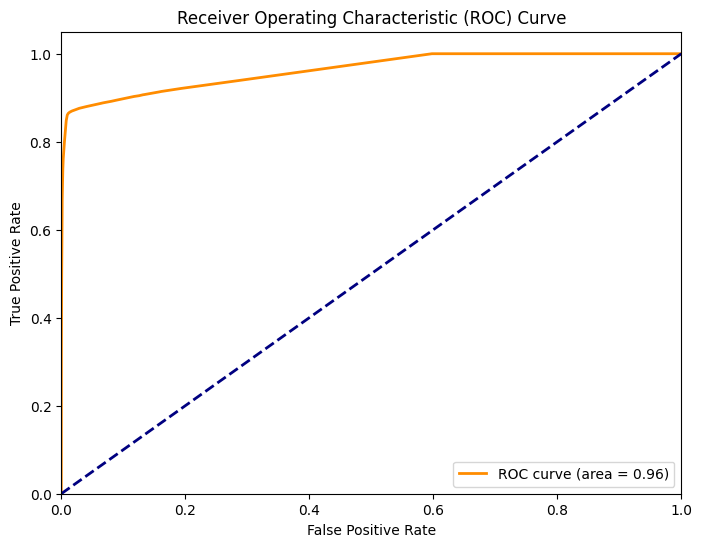

C:\Users\tansw\AppData\Local\Temp\ipykernel_10172\832386307.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='muted')


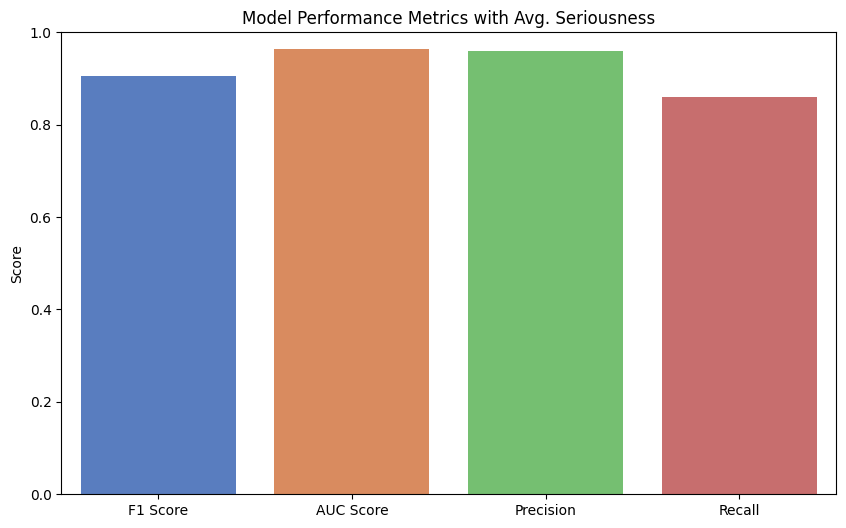

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc

predictions_prob = model_enriched_with_avg_seriousness.predict([X_test_seqs, X_test_scores, X_test_seriousness])
predictions = (predictions_prob > 0.5).astype("int32")

f1 = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test, predictions_prob)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"F1 Score: {f1}")
print(f"AUC Score: {auc_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

metrics = ['F1 Score', 'AUC Score', 'Precision', 'Recall']
values = [f1, auc_score, precision, recall]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Model Performance Metrics with Avg. Seriousness')
plt.ylabel('Score')
plt.ylim(0, 1) 
plt.show()

Despite several constraints pertaining to the dataset and the descriptions' comprehensiveness (or lack thereof), we notice improvements on all scores!

We save our model

In [24]:
model_enriched_with_avg_seriousness.save('model_enriched_with_avg_seriousness.keras') 

Widget to prediction resolution status


In [ ]:
import ipywidgets as widgets
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_enriched['mos']) 

max_seq_length = max([len(seq) for seq in tokenizer.texts_to_sequences(df_enriched['mos'])])

model = load_model('my_transformer_model.keras')

def predict_mos(mos_string):
    seq = tokenizer.texts_to_sequences([mos_string])
    padded_seq = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    
    prediction = model.predict(padded_seq)
    
    confidence = prediction[0][0]
    result = "Floor" if confidence >= 0.5 else "Resolved"
    print(f"{result}")

text = widgets.Text(
    value='',
    placeholder='Type something',
    description='MOS String:',
    disabled=False
)

display(text)

def on_type(change):
    new_text = change['new']
    text_without_spaces = new_text.replace(" ", "")
    
    if len(text_without_spaces) % 2 == 0 and not new_text.endswith(" "):
        predict_mos(new_text)

text.observe(on_type, names='value')



Text(value='', description='MOS String:', placeholder='Type something')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Floor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Floor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Resolved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Resolved
1/1 ━━━━━━━━━━━━━━